In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import sys
sys.path.append('../')
from eda import utils

In [2]:
tracks = utils.load('../data/fma_metadata/tracks.csv')
features = utils.load('../data/fma_metadata/features.csv')

In [3]:
from sklearn.preprocessing import StandardScaler


def get_all():
    large = tracks['set', 'subset'] <= 'small'

    genre1 = tracks['track', 'genre_top'] == 'Rock'
    genre2 = tracks['track', 'genre_top'] == 'Pop'
    genre3 = tracks['track', 'genre_top'] == 'Electronic'
    genre4 = tracks['track', 'genre_top'] == 'Instrumental'
    genre5 = tracks['track', 'genre_top'] == 'Hip-Hop'

    train = tracks['set', 'split'] == 'training'
    val = tracks['set', 'split'] == 'validation'
    test = tracks['set', 'split'] == 'test'

    y_train = tracks.loc[large & train & (
        genre1 | genre2 | genre3 | genre4 | genre5), ('track', 'genre_top')]
    y_test = tracks.loc[large & test & (
        genre1 | genre2 | genre3 | genre4 | genre5), ('track', 'genre_top')]
    X_train = features.loc[large & train & (
        genre1 | genre2 | genre3 | genre4 | genre5)]
    X_test = features.loc[large & test & (
        genre1 | genre2 | genre3 | genre4 | genre5)]
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_all()
X_train.shape


(4000, 518)

In [4]:
from sklearn.decomposition import PCA
def pca_preprocess(X_train, X_test):
	X_train = StandardScaler().fit_transform(X_train)
	X_test = StandardScaler().fit_transform(X_test)
	pca = PCA(n_components=10)
	pca.fit(X_train)
	print("Explained Variance", pca.explained_variance_ratio_[:10])
	print("Singular Values", pca.singular_values_[:10])
	X_train = pca.fit_transform(X_train)
	X_test = pca.transform(X_test)
	return X_train, X_test

In [5]:
X_train, X_test = pca_preprocess(X_train, X_test)
X_train.shape

c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


Explained Variance [0.11254415 0.07531811 0.04454353 0.0305036  0.02896338 0.02675327
 0.02527428 0.02436089 0.02299827 0.01977059]
Singular Values [482.89903593 395.04318079 303.79958676 251.4029748  244.97370897
 235.44164856 228.84122483 224.66810103 218.29432211 202.39731392]


(4000, 10)

In [6]:
y_test.unique()

['Rock', 'Instrumental', 'Pop', 'Hip-Hop', 'Electronic']
Categories (5, object): ['Rock', 'Instrumental', 'Pop', 'Hip-Hop', 'Electronic']

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [10, 100, 200, 300, 500, 1000],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

knn = RandomizedSearchCV(KNeighborsClassifier(), param_grid, cv=5,
                         return_train_score=False,
                         n_iter=6)
knn.fit(X_train, y_train)

knn.best_params_


{'weights': 'distance', 'n_neighbors': 100, 'algorithm': 'brute'}

In [8]:
pd.DataFrame(knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_n_neighbors,param_algorithm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003999,1.095584e-03,0.082475,0.005947,uniform,300,auto,"{'weights': 'uniform', 'n_neighbors': 300, 'al...",0.47625,0.52375,0.52375,0.53000,0.52625,0.51600,0.020006,4
1,0.002999,2.708334e-06,0.060756,0.001178,distance,200,kd_tree,"{'weights': 'distance', 'n_neighbors': 200, 'a...",0.47000,0.53750,0.52250,0.54125,0.53750,0.52175,0.026665,2
2,0.003561,4.621857e-04,0.032800,0.000748,uniform,10,auto,"{'weights': 'uniform', 'n_neighbors': 10, 'alg...",0.45500,0.50875,0.52625,0.53625,0.52875,0.51100,0.029415,5
3,0.002198,4.005853e-04,0.070377,0.004166,distance,200,brute,"{'weights': 'distance', 'n_neighbors': 200, 'a...",0.47000,0.53750,0.52250,0.54125,0.53750,0.52175,0.026665,2
4,0.002000,1.168008e-07,0.051961,0.003296,distance,100,brute,"{'weights': 'distance', 'n_neighbors': 100, 'a...",0.48000,0.53500,0.53625,0.53375,0.55250,0.52750,0.024711,1
5,0.005470,4.765860e-03,0.180451,0.010069,distance,1000,ball_tree,"{'weights': 'distance', 'n_neighbors': 1000, '...",0.43500,0.50500,0.50125,0.49875,0.51250,0.49050,0.028136,6


              precision    recall  f1-score   support

  Electronic       0.68      0.23      0.34       100
     Hip-Hop       0.51      0.80      0.62       100
Instrumental       0.69      0.73      0.71       100
         Pop       0.57      0.53      0.55       100
        Rock       0.70      0.76      0.73       100

    accuracy                           0.61       500
   macro avg       0.63      0.61      0.59       500
weighted avg       0.63      0.61      0.59       500



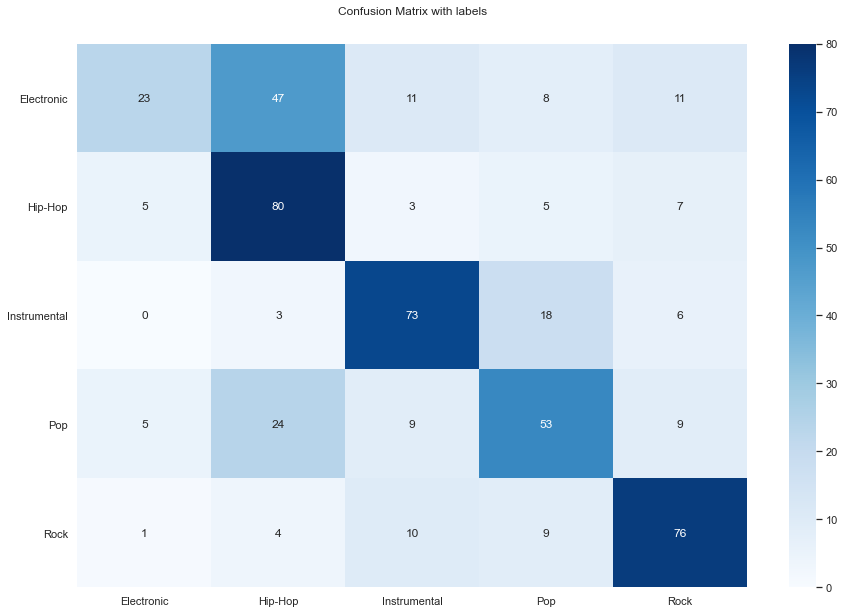

In [9]:
neigh = KNeighborsClassifier(n_neighbors=100, weights="distance", algorithm="ball_tree")
y_pred = neigh.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_pred))
cf_mat = confusion_matrix(y_test, y_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(neigh.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(neigh.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

plt.show()

In [10]:
from sklearn.manifold import TSNE

def tsne_preprocess(X_train, X_test):
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    tsne = TSNE(n_components=2)
    tsne.fit(X_train)
    X_train = tsne.fit_transform(X_train)
    X_test = tsne.fit_transform(X_test)
    return X_train, X_test

X_train.shape


(4000, 10)

In [11]:
X_train, X_test, y_train, y_test = get_all()
X_train, X_test = tsne_preprocess(X_train, X_test)

c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklea

              precision    recall  f1-score   support

  Electronic       0.50      0.07      0.12       100
     Hip-Hop       0.32      0.36      0.34       100
Instrumental       0.16      0.03      0.05       100
         Pop       0.26      0.73      0.38       100
        Rock       0.08      0.06      0.07       100

    accuracy                           0.25       500
   macro avg       0.26      0.25      0.19       500
weighted avg       0.26      0.25      0.19       500



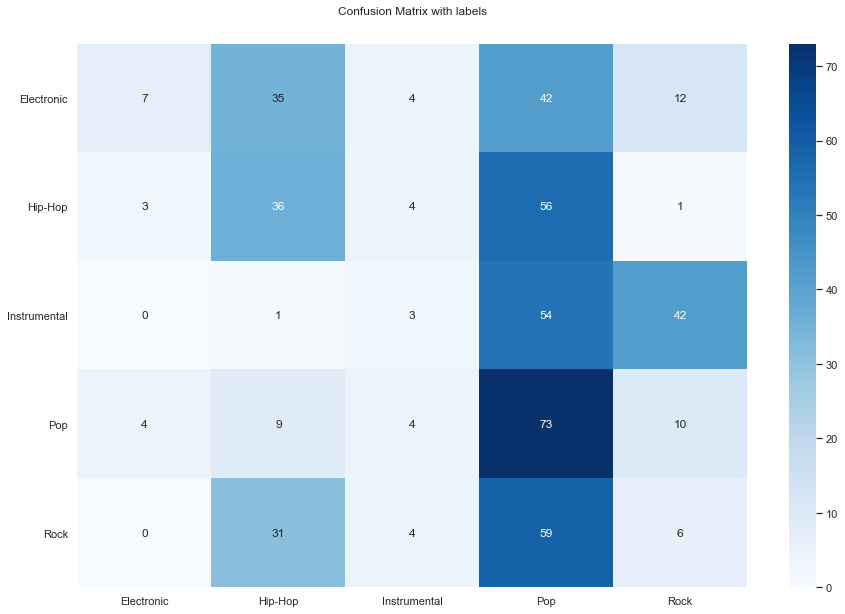

In [12]:
neigh = KNeighborsClassifier(n_neighbors=100, weights="distance", algorithm="ball_tree")
y_pred = neigh.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_pred))
cf_mat = confusion_matrix(y_test, y_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(neigh.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(neigh.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

plt.show()